In [1]:
import os
import os.path
import numpy as np
import logging
import argparse
import pycuda.driver as cuda
import matplotlib.pyplot as plt

import torch
import torchvision

from torch.utils.tensorboard import SummaryWriter

import global_v as glv
from network_parser import parse
from datasets import load_dataset_snn, load_dataset_snn2, load_dataset_snn3
from utils import aboutCudaDevices
from utils import AverageMeter
from utils import CountMulAddSNN, CountMulAddANN
import fsvae_models.fsvae as fsvae
import ann_models.ann_vae as ann_vae
from fsvae_models.snn_layers import LIFSpike
import metrics.inception_score as inception_score
import metrics.clean_fid as clean_fid
import metrics.autoencoder_fid as autoencoder_fid

from tqdm.notebook import trange
from ann_models import *


max_accuracy = 0
min_loss = 1000


In [2]:
def add_hook(net):
    if glv.network_config['spiking']:
        count_mul_add = CountMulAddSNN()
        hook_handles = []
        for m in net.modules():
            if isinstance(m, torch.nn.Conv3d) or isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.ConvTranspose3d) or isinstance(m, LIFSpike):
                handle = m.register_forward_hook(count_mul_add)
                hook_handles.append(handle)
    else:
        count_mul_add = CountMulAddANN()
        hook_handles = []
        for m in net.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.ConvTranspose2d):
                handle = m.register_forward_hook(count_mul_add)
                hook_handles.append(handle)

    return count_mul_add, hook_handles



def write_weight_hist(net, index):
    for n, m in net.named_parameters():
        root, name = os.path.splitext(n)
        writer.add_histogram(root + '/' + name, m, index)

def train(network, trainloader, opti, epoch):
    n_steps = glv.network_config['n_steps']
    max_epoch = glv.network_config['epochs']
    
    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()


    network = network.train()
    
    for batch_idx, (real_img, targets) in enumerate(trainloader):  
        opti.zero_grad()
        real_img = real_img.to(init_device, non_blocking=True)
        targets = targets.to(init_device, non_blocking=True)


        if network_config['loss_func'] == 'mmd':
            # direct spike input
            spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps) # (N,C,H,W,T)
            x_recon, q_z, p_z, sampled_z = network(spike_input, scheduled=network_config['scheduled']) # sampled_z(B,C,1,1,T)
            losses = network.loss_function_mmd(targets, x_recon, q_z, p_z)
            #losses = network.loss_function_mmd(real_img, x_recon, q_z, p_z)
        elif network_config['loss_func'] == 'kld':
            x_recon, q_z, p_z = network(real_img)
            losses = network.loss_function_kld(x_recon, targets, q_z, p_z)
        else:
            raise ValueError('unrecognized loss function')
        
        losses['loss'].backward()
        
        opti.step()

        loss_meter.update(losses['loss'].detach().cpu().item())
        recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
        dist_meter.update(losses['Distance_Loss'].detach().cpu().item())


        print(f'Train[{epoch}/{max_epoch}] [{batch_idx}/{len(trainloader)}] Loss: {loss_meter.avg}, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')

        if batch_idx == len(trainloader)-1:
            os.makedirs(f'checkpoint/{args.name}/imgs/train/', exist_ok=True)
            torchvision.utils.save_image((real_img+1)/2, f'checkpoint/{args.name}/imgs/train/epoch{epoch}_input.png')
            torchvision.utils.save_image((x_recon+1)/2, f'checkpoint/{args.name}/imgs/train/epoch{epoch}_recons.png')


    logging.info(f"Train [{epoch}] Loss: {loss_meter.avg} ReconsLoss: {recons_meter.avg} DISTANCE: {dist_meter.avg}")

    

    #writer.add_image('Train/mean_sampled_z', mean_sampled_z.unsqueeze(0), epoch)

    return loss_meter.avg


def test(network, testloader, epoch):
    n_steps = glv.network_config['n_steps']
    max_epoch = glv.network_config['epochs']

    loss_meter = AverageMeter()
    recons_meter = AverageMeter()
    dist_meter = AverageMeter()

    count_mul_add, hook_handles = add_hook(net)

    network = network.eval()
    with torch.no_grad():
        for batch_idx, (real_img, targets) in enumerate(testloader):   
            real_img = real_img.to(init_device, non_blocking=True)
            targets = targets.to(init_device, non_blocking=True)

            if network_config['loss_func'] == 'mmd':
                # direct spike input
                spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps) # (N,C,H,W,T)
                x_recon, q_z, p_z, sampled_z = network(spike_input, scheduled=network_config['scheduled'])
                losses = network.loss_function_mmd(targets, x_recon, q_z, p_z)
                #losses = network.loss_function_mmd(real_img, x_recon, q_z, p_z)
                print(f'Test/mul [{epoch}]: {count_mul_add.mul_sum.item() / len(testloader)}')
                print(f'Test/add [{epoch}]: {count_mul_add.add_sum.item() / len(testloader)}')
            elif network_config['loss_func'] == 'kld':
                x_recon, q_z, p_z = network(real_img)
                losses = network.loss_function_kld(targets, x_recon, q_z, p_z)
                print(f'Test/mul [{epoch}]: {count_mul_add.mul_sum / len(testloader)}')
                print(f'Test/add [{epoch}]: {count_mul_add.add_sum / len(testloader)}')
            else:
                raise ValueError('unrecognized loss function')

            loss_meter.update(losses['loss'].detach().cpu().item())
            recons_meter.update(losses['Reconstruction_Loss'].detach().cpu().item())
            dist_meter.update(losses['Distance_Loss'].detach().cpu().item())

            print(f'Test[{epoch}/{max_epoch}] [{batch_idx}/{len(testloader)}] Loss: {loss_meter.avg}, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')

            if batch_idx == len(testloader)-1:
                os.makedirs(f'checkpoint/{args.name}/imgs/test/', exist_ok=True)
                torchvision.utils.save_image((real_img+1)/2, f'checkpoint/{args.name}/imgs/test/epoch{epoch}_input.png')
                torchvision.utils.save_image((x_recon+1)/2, f'checkpoint/{args.name}/imgs/test/epoch{epoch}_recons.png')

    logging.info(f"Test [{epoch}] Loss: {loss_meter.avg} ReconsLoss: {recons_meter.avg} DISTANCE: {dist_meter.avg}")
    
    for handle in hook_handles:
        handle.remove()

    return loss_meter.avg
        

def plot(network, testloader, index):
    n_steps = glv.network_config['n_steps']
    max_epoch = glv.network_config['epochs']

    count_mul_add, hook_handles = add_hook(net)

    network = network.eval()
    with torch.no_grad():
        for batch_idx, (real_img, targets) in enumerate(testloader):   
            if batch_idx == index:
                
                real_img = real_img.to(init_device, non_blocking=True)
                targets = targets.to(init_device, non_blocking=True)
                if glv.network_config['spiking']:
                    # direct spike input
                    spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, n_steps) # (N,C,H,W,T)
                    x_recon, q_z, p_z, sampled_z = network(spike_input, scheduled=network_config['scheduled']) # sampled_z(B,C,1,1,T)
                else:
                    # direct input
                    x_recon, mu, logvar = network(real_img)
                
                
                os.makedirs(f'checkpoint/{args.name}/imgs/test/', exist_ok=True)
                torchvision.utils.save_image((real_img+1)/2, f'checkpoint/{args.name}/imgs/test/input.png')
                torchvision.utils.save_image((x_recon+1)/2, f'checkpoint/{args.name}/imgs/test/recons.png')
                
                real_img = np.transpose(real_img.cpu().numpy(), (0,2,3,1))
                # reshape x_recon to use matplotlib
                x_recon = np.transpose(x_recon.cpu().numpy(), (0, 2, 3, 1))
                
                real_img = (real_img+1)/2
                x_recon = (x_recon+1)/2
                
                N = 2*x_recon.shape[0]
                if N>4:
                    cols = 4
                    rows = int(np.ceil(N/4))
                else:
                    cols = N
                    rows = 1
                fig, axes = plt.subplots(rows, cols, figsize=(10,20))
                for i, ax in enumerate(axes.flat):
                    if i < N:
                        if i % 2 == 0:
                            ax.imshow(real_img[int(i//2)])
                            ax.axis('off')
                        else:
                            ax.imshow(x_recon[int(i//2)])
                            ax.axis('off')
                    else:
                        ax.axis('off')
                        
                plt.subplots_adjust(wspace=0.1, hspace=0.1)
                plt.show()

                return
    return


In [3]:
class Args:
    def __init__(self, checkpoint=None, config="", device=None, name=""):
        self.checkpoint = checkpoint
        self.config = config
        self.device = device
        self.name = name

checkpoint_ann='checkpoint/ann_model_test/best.pth'
args = Args(checkpoint=checkpoint_ann, config='NetworkConfigs/ToyCelebA_ANN.yaml', device=None, name='ann_model_test')

if args.device is None:
    init_device = torch.device("cuda:0")
else:
    init_device = torch.device(f"cuda:{args.device}")
    
os.makedirs(f'checkpoint/{args.name}', exist_ok=True)
writer = SummaryWriter(log_dir=f'checkpoint/{args.name}/tb')
logging.basicConfig(filename=f'checkpoint/{args.name}/{args.name}.log', level=logging.INFO)
    
logging.info("start parsing settings")
    
params = parse(args.config)
network_config = params['Network']

if network_config.get('out_channels') is None:
    network_config['out_channels'] = network_config['in_channels']
    
logging.info("finish parsing settings")
logging.info(network_config)
print(network_config)
        
# Check whether a GPU is available
if torch.cuda.is_available():
    cuda.init()
    c_device = aboutCudaDevices()
    print(c_device.info())
    print("selected device: ", args.device)
else:
    raise Exception("only support gpu")
    
glv.init(network_config, [args.device])

dataset_name = glv.network_config['dataset']

logging.info("dataset loading...")

if dataset_name == "ToyCelebA":
    input_data_path = glv.network_config['input_data_path']
    output_data_path = glv.network_config['output_data_path']
    input_data_path = os.path.expanduser(input_data_path)
    output_data_path = os.path.expanduser(output_data_path)
    train_loader, test_loader = load_dataset_snn2.load_toyceleba(input_data_path, output_data_path)
else:
    data_path = glv.network_config['data_path']

    if dataset_name == "MNIST":
        data_path = os.path.expanduser(data_path)
        train_loader, test_loader = load_dataset_snn.load_mnist(data_path)
    elif dataset_name == "FashionMNIST":
        data_path = os.path.expanduser(data_path)
        train_loader, test_loader = load_dataset_snn.load_fashionmnist(data_path)

    elif dataset_name == "CIFAR10":
        data_path = os.path.expanduser(data_path)
        train_loader, test_loader = load_dataset_snn.load_cifar10(data_path)

    elif dataset_name == "CelebA":
        data_path = os.path.expanduser(data_path)
        train_loader, test_loader = load_dataset_snn.load_celebA(data_path)

    else:
        raise Exception('Unrecognized dataset name.')
logging.info("dataset loaded")

if network_config['model'] == 'FSVAE':
    net = fsvae.FSVAE()
elif network_config['model'] == 'FSVAE_large':
    net = fsvae.FSVAELarge()
elif network_config['model'] == 'FSVAE_small':
    net = fsvae.FSVAESmall()
elif network_config['model'] == 'FSAE_small':
    net = fsvae.FSAESmall()
elif network_config['model'] == 'VanillaVAE_large':
    net = ann_vae.VanillaVAELarge()
elif network_config['model'] == 'AE':
    net = ann_ae.AE()
elif network_config['model'] == 'AE_large':
    net = ann_ae.AELarge()
else:
    raise Exception('not defined model')

net = net.to(init_device)
    
if args.checkpoint is not None:
    checkpoint_path = args.checkpoint
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint)    


{'epochs': 50, 'batch_size': 40, 'n_steps': 8, 'dataset': 'ToyCelebA', 'in_channels': 3, 'out_channels': 3, 'input_data_path': 'C:/Users/Brhan/OneDrive/Belgeler/KuOnline/Spring24/Elec491/SNN/dataset/img_align_celeba_sketch', 'output_data_path': 'C:/Users/Brhan/OneDrive/Belgeler/KuOnline/Spring24/Elec491/SNN/dataset/img_align_celeba', 'lr': 0.001, 'latent_dim': 128, 'input_size': 32, 'model': 'VanillaVAE_large', 'k': 20, 'scheduled': False, 'loss_func': 'kld', 'spiking': False}
1 device(s) found:
    1) NVIDIA GeForce GTX 1650 (Id: 0)
          Memory: 4.29 GB

selected device:  None
loading ToyCelebA


In [4]:
# Train loop    

optimi = 'adam'
if optimi == 'adam':
    optimizer = torch.optim.AdamW(net.parameters(), 
                                lr=glv.network_config['lr'], 
                                betas=(0.9, 0.999), 
                                weight_decay=0.001)
elif optimi == 'sgd':
    optimizer = torch.optim.SGD(net.parameters(), 
                                lr=glv.network_config['lr'],
                                momentum = 0.9)
else:
    raise Exception('unidentified optimizer: use adam or sgd')


best_loss = 1e8
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for e in trange(glv.network_config['epochs']):
        
    write_weight_hist(net, e)
    train_loss = train(net, train_loader, optimizer, e)
    test_loss = test(net, test_loader, e)
#    scheduler.step()

    torch.save(net.state_dict(), f'checkpoint/{args.name}/checkpoint.pth')
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(net.state_dict(), f'checkpoint/{args.name}/best.pth')

#    sample(net, e, batch_size=2)
#    calc_inception_score(net, e)
#    calc_autoencoder_frechet_distance(net, e)
#    calc_clean_fid(net, e)
        
writer.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Train[0/50] [0/50] Loss: 0.12369392812252045, RECONS: 0.12369005382061005, DISTANCE: 387.15191650390625
Train[0/50] [1/50] Loss: 0.11440049484372139, RECONS: 0.1143965795636177, DISTANCE: 391.5475616455078
Train[0/50] [2/50] Loss: 0.11922464519739151, RECONS: 0.11922071874141693, DISTANCE: 392.6378987630208
Train[0/50] [3/50] Loss: 0.12209716252982616, RECONS: 0.12209324911236763, DISTANCE: 391.3172607421875
Train[0/50] [4/50] Loss: 0.12550815790891648, RECONS: 0.12550423741340638, DISTANCE: 392.0050842285156
Train[0/50] [5/50] Loss: 0.12413714701930682, RECONS: 0.12413321062922478, DISTANCE: 393.62180582682294
Train[0/50] [6/50] Loss: 0.12643169185944966, RECONS: 0.12642775156668254, DISTANCE: 394.0704084123884
Train[0/50] [7/50] Loss: 0.1260076891630888, RECONS: 0.12600373569875956, DISTANCE: 395.3912544250488
Train[0/50] [8/50] Loss: 0.12613930139276716, RECONS: 0.12613534182310104, DISTANCE: 396.0653788248698
Train[0/50] [9/50] Loss: 0.12648980021476747, RECONS: 0.12648583427071572

Train[1/50] [30/50] Loss: 0.1289890055214205, RECONS: 0.1289849077020922, DISTANCE: 409.7965619487147
Train[1/50] [31/50] Loss: 0.12889774213545024, RECONS: 0.1288936424534768, DISTANCE: 409.9714984893799
Train[1/50] [32/50] Loss: 0.1290922939325824, RECONS: 0.12908819114620035, DISTANCE: 410.28424719608194
Train[1/50] [33/50] Loss: 0.12956519359174898, RECONS: 0.1295610896366484, DISTANCE: 410.39973808737363
Train[1/50] [34/50] Loss: 0.12962338988270078, RECONS: 0.1296192839741707, DISTANCE: 410.5849129813058
Train[1/50] [35/50] Loss: 0.1293630697247055, RECONS: 0.1293589605225457, DISTANCE: 410.90882280137805
Train[1/50] [36/50] Loss: 0.12958139644281283, RECONS: 0.12957728593736081, DISTANCE: 411.0326397870038
Train[1/50] [37/50] Loss: 0.1297355876549294, RECONS: 0.1297314743462362, DISTANCE: 411.3230462325247
Train[1/50] [38/50] Loss: 0.1296315447260172, RECONS: 0.12962742913991976, DISTANCE: 411.563713660607
Train[1/50] [39/50] Loss: 0.12970512080937624, RECONS: 0.1297010030597448

Train[3/50] [10/50] Loss: 0.1274383379654451, RECONS: 0.1274340423670682, DISTANCE: 429.69084028764206
Train[3/50] [11/50] Loss: 0.12856650849183401, RECONS: 0.1285622144738833, DISTANCE: 429.5260696411133
Train[3/50] [12/50] Loss: 0.12837397020596725, RECONS: 0.1283696752328139, DISTANCE: 429.6090299166166
Train[3/50] [13/50] Loss: 0.12815446938787187, RECONS: 0.1281501746603421, DISTANCE: 429.54507228306363
Train[3/50] [14/50] Loss: 0.12862611711025237, RECONS: 0.12862182557582855, DISTANCE: 429.2692159016927
Train[3/50] [15/50] Loss: 0.12911696266382933, RECONS: 0.1291126711294055, DISTANCE: 429.2666473388672
Train[3/50] [16/50] Loss: 0.1285850694950889, RECONS: 0.12858077664585674, DISTANCE: 429.40456973805146
Train[3/50] [17/50] Loss: 0.12762953465183577, RECONS: 0.1276252410478062, DISTANCE: 429.47956000434027
Train[3/50] [18/50] Loss: 0.1275468660812629, RECONS: 0.1275425749389749, DISTANCE: 429.19320518092104
Train[3/50] [19/50] Loss: 0.12854952476918696, RECONS: 0.128545234352

Train[4/50] [38/50] Loss: 0.12460151735024574, RECONS: 0.12459710297676233, DISTANCE: 441.3220621744792
Train[4/50] [39/50] Loss: 0.12488161325454712, RECONS: 0.12487719785422087, DISTANCE: 441.4317352294922
Train[4/50] [40/50] Loss: 0.12491201264102285, RECONS: 0.12490759626394365, DISTANCE: 441.5389285203887
Train[4/50] [41/50] Loss: 0.12553079106978007, RECONS: 0.1255263758911973, DISTANCE: 441.43280828566776
Train[4/50] [42/50] Loss: 0.1251691552095635, RECONS: 0.12516473944103995, DISTANCE: 441.50109721339027
Train[4/50] [43/50] Loss: 0.12529420920393683, RECONS: 0.12528979117897424, DISTANCE: 441.7175695245916
Train[4/50] [44/50] Loss: 0.12504015531804827, RECONS: 0.125035736295912, DISTANCE: 441.8260986328125
Train[4/50] [45/50] Loss: 0.12523876778457477, RECONS: 0.12523434732271277, DISTANCE: 441.9676639722741
Train[4/50] [46/50] Loss: 0.12529606800130072, RECONS: 0.12529164584393196, DISTANCE: 442.13876147980386
Train[4/50] [47/50] Loss: 0.12528054447223744, RECONS: 0.12527612

Train[6/50] [19/50] Loss: 0.11801767535507679, RECONS: 0.11801308579742908, DISTANCE: 458.86683044433596
Train[6/50] [20/50] Loss: 0.11810180686769031, RECONS: 0.11809721872920081, DISTANCE: 458.74539765857514
Train[6/50] [21/50] Loss: 0.1182960918681188, RECONS: 0.1182915023104711, DISTANCE: 458.90259205211294
Train[6/50] [22/50] Loss: 0.11830302263083665, RECONS: 0.11829843210137408, DISTANCE: 458.99552851137906
Train[6/50] [23/50] Loss: 0.11768947479625542, RECONS: 0.11768488337596257, DISTANCE: 459.0972557067871
Train[6/50] [24/50] Loss: 0.11773883610963821, RECONS: 0.11773424863815307, DISTANCE: 458.70283203125
Train[6/50] [25/50] Loss: 0.11775211273477627, RECONS: 0.11774752432337174, DISTANCE: 458.8115539550781
Train[6/50] [26/50] Loss: 0.11760708358552721, RECONS: 0.11760249457977436, DISTANCE: 458.8681866681134
Train[6/50] [27/50] Loss: 0.11729092337191105, RECONS: 0.11728633354817118, DISTANCE: 458.9581832885742
Train[6/50] [28/50] Loss: 0.1179446539488332, RECONS: 0.11794006

Train[7/50] [48/50] Loss: 0.11919480030025754, RECONS: 0.11919017561844417, DISTANCE: 462.49261536890145
Train[7/50] [49/50] Loss: 0.11966246768832206, RECONS: 0.11965784132480621, DISTANCE: 462.66770629882814
Test/mul [7]: 364216320.0
Test/add [7]: 365028864.0
Test[7/50] [0/1] Loss: 1.2423715591430664, RECONS: 1.2423659563064575, DISTANCE: 559.9512939453125
Train[8/50] [0/50] Loss: 0.12343178689479828, RECONS: 0.12342702597379684, DISTANCE: 476.2284240722656
Train[8/50] [1/50] Loss: 0.11713393777608871, RECONS: 0.11712918430566788, DISTANCE: 475.25274658203125
Train[8/50] [2/50] Loss: 0.11819623907407124, RECONS: 0.1181914856036504, DISTANCE: 475.2921956380208
Train[8/50] [3/50] Loss: 0.1153018157929182, RECONS: 0.11529708094894886, DISTANCE: 473.44715118408203
Train[8/50] [4/50] Loss: 0.11628489196300507, RECONS: 0.11628017723560333, DISTANCE: 471.409326171875
Train[8/50] [5/50] Loss: 0.11570239439606667, RECONS: 0.11569768438736598, DISTANCE: 470.95953877766925
Train[8/50] [6/50] Lo

Train[9/50] [27/50] Loss: 0.11698023708803314, RECONS: 0.11697551235556602, DISTANCE: 472.31082698277066
Train[9/50] [28/50] Loss: 0.1169576059127676, RECONS: 0.11695288198775258, DISTANCE: 472.2464283910291
Train[9/50] [29/50] Loss: 0.11753355463345845, RECONS: 0.11752883121371269, DISTANCE: 472.1773305257162
Train[9/50] [30/50] Loss: 0.1175892545330909, RECONS: 0.11758452822123805, DISTANCE: 472.46851570375503
Train[9/50] [31/50] Loss: 0.11771927261725068, RECONS: 0.11771454452537, DISTANCE: 472.6629571914673
Train[9/50] [32/50] Loss: 0.11844760992310265, RECONS: 0.11844288106217529, DISTANCE: 472.7348743785511
Train[9/50] [33/50] Loss: 0.11807337052681867, RECONS: 0.11806864094208269, DISTANCE: 472.8103224810432
Train[9/50] [34/50] Loss: 0.11842864964689527, RECONS: 0.11842391895396369, DISTANCE: 472.9242030552455
Train[9/50] [35/50] Loss: 0.11853315039641327, RECONS: 0.11852841638028622, DISTANCE: 473.26294199625653
Train[9/50] [36/50] Loss: 0.11872323199703887, RECONS: 0.118718496

Train[11/50] [3/50] Loss: 0.11062324605882168, RECONS: 0.1106183361262083, DISTANCE: 491.0580368041992
Train[11/50] [4/50] Loss: 0.10874155610799789, RECONS: 0.10873663574457168, DISTANCE: 492.0738891601562
Train[11/50] [5/50] Loss: 0.1135920745631059, RECONS: 0.11358714227875073, DISTANCE: 493.14173380533856
Train[11/50] [6/50] Loss: 0.11209262481757573, RECONS: 0.11208768721137728, DISTANCE: 493.7394278390067
Train[11/50] [7/50] Loss: 0.11000762786716223, RECONS: 0.11000269744545221, DISTANCE: 493.02212142944336
Train[11/50] [8/50] Loss: 0.11105156689882278, RECONS: 0.11104663709799449, DISTANCE: 492.9304606119792
Train[11/50] [9/50] Loss: 0.11177902743220329, RECONS: 0.11177409663796425, DISTANCE: 493.0627899169922
Train[11/50] [10/50] Loss: 0.11185757951302962, RECONS: 0.11185264858332547, DISTANCE: 493.0731867009943
Train[11/50] [11/50] Loss: 0.11555780346194904, RECONS: 0.11555286745230357, DISTANCE: 493.5420557657878
Train[11/50] [12/50] Loss: 0.115486462528889, RECONS: 0.115481

Train[12/50] [32/50] Loss: 0.12052272711739395, RECONS: 0.12051774313052495, DISTANCE: 498.4462049079664
Train[12/50] [33/50] Loss: 0.12013813940917745, RECONS: 0.12013315168373725, DISTANCE: 498.8289830824908
Train[12/50] [34/50] Loss: 0.12039601717676435, RECONS: 0.12039102890661785, DISTANCE: 498.89823085239954
Train[12/50] [35/50] Loss: 0.12051197638114293, RECONS: 0.12050698759655158, DISTANCE: 498.94173346625433
Train[12/50] [36/50] Loss: 0.11989297395622409, RECONS: 0.11988798448362865, DISTANCE: 499.0169883934227
Train[12/50] [37/50] Loss: 0.11957075191955817, RECONS: 0.11956576199123733, DISTANCE: 499.0697310598273
Train[12/50] [38/50] Loss: 0.11960904873334445, RECONS: 0.11960405779954715, DISTANCE: 499.1771255884415
Train[12/50] [39/50] Loss: 0.11966527923941613, RECONS: 0.11966028716415167, DISTANCE: 499.29633407592775
Train[12/50] [40/50] Loss: 0.11963916733497526, RECONS: 0.11963417508253237, DISTANCE: 499.31807206316694
Train[12/50] [41/50] Loss: 0.1192778114761625, RECO

Train[14/50] [10/50] Loss: 0.11033785546367819, RECONS: 0.11033274572003972, DISTANCE: 510.95250077681106
Train[14/50] [11/50] Loss: 0.10887128487229347, RECONS: 0.10886617377400398, DISTANCE: 511.07861582438153
Train[14/50] [12/50] Loss: 0.10912525997712062, RECONS: 0.1091201500250743, DISTANCE: 510.941157414363
Train[14/50] [13/50] Loss: 0.10852939635515213, RECONS: 0.10852428685341563, DISTANCE: 510.8755078996931
Train[14/50] [14/50] Loss: 0.10964519282182057, RECONS: 0.10964008619387945, DISTANCE: 510.62079060872395
Train[14/50] [15/50] Loss: 0.1095688478089869, RECONS: 0.10956374416127801, DISTANCE: 510.3273620605469
Train[14/50] [16/50] Loss: 0.10919636400306926, RECONS: 0.10919125991709092, DISTANCE: 510.3753338982077
Train[14/50] [17/50] Loss: 0.11035116513570149, RECONS: 0.1103460623158349, DISTANCE: 510.28391520182294
Train[14/50] [18/50] Loss: 0.11090143495484402, RECONS: 0.11089633013072767, DISTANCE: 510.47044292249177
Train[14/50] [19/50] Loss: 0.11084485910832882, RECONS

Train[15/50] [40/50] Loss: 0.11193202744896819, RECONS: 0.11192685747291983, DISTANCE: 516.9988127917778
Train[15/50] [41/50] Loss: 0.11196500985395341, RECONS: 0.11195983897362437, DISTANCE: 517.0946953183129
Train[15/50] [42/50] Loss: 0.11215670476126116, RECONS: 0.11215153319198032, DISTANCE: 517.1570072617642
Train[15/50] [43/50] Loss: 0.1119943293319507, RECONS: 0.11198915896767919, DISTANCE: 517.0314129916104
Train[15/50] [44/50] Loss: 0.11197481254736583, RECONS: 0.1119696428378423, DISTANCE: 516.9658589680989
Train[15/50] [45/50] Loss: 0.11225398224980934, RECONS: 0.11224881219475166, DISTANCE: 516.9957109534222
Train[15/50] [46/50] Loss: 0.11233636514937624, RECONS: 0.11233119539757992, DISTANCE: 516.9663858616606
Train[15/50] [47/50] Loss: 0.11244286907215913, RECONS: 0.1124376985244453, DISTANCE: 517.0467662811279
Train[15/50] [48/50] Loss: 0.11267072722619893, RECONS: 0.11266555743558067, DISTANCE: 516.9650984783561
Train[15/50] [49/50] Loss: 0.11270803451538086, RECONS: 0.

Train[17/50] [19/50] Loss: 0.11097081899642944, RECONS: 0.11096556708216668, DISTANCE: 525.2529846191406
Train[17/50] [20/50] Loss: 0.11159671949488777, RECONS: 0.11159146612598783, DISTANCE: 525.4073311941964
Train[17/50] [21/50] Loss: 0.11156321554021402, RECONS: 0.11155795949426564, DISTANCE: 525.6750516024503
Train[17/50] [22/50] Loss: 0.11147069639485815, RECONS: 0.11146544146796931, DISTANCE: 525.5642195991848
Train[17/50] [23/50] Loss: 0.11167673921833436, RECONS: 0.11167148097107808, DISTANCE: 525.8824844360352
Train[17/50] [24/50] Loss: 0.1118009015917778, RECONS: 0.11179564148187637, DISTANCE: 526.062255859375
Train[17/50] [25/50] Loss: 0.11140888298933323, RECONS: 0.11140362689128289, DISTANCE: 525.6508249136118
Train[17/50] [26/50] Loss: 0.11109714927496733, RECONS: 0.11109189082075048, DISTANCE: 525.8892505787037
Train[17/50] [27/50] Loss: 0.11138924131436008, RECONS: 0.11138397747916835, DISTANCE: 526.4276014055524
Train[17/50] [28/50] Loss: 0.11096370708325813, RECONS: 0

Train[18/50] [47/50] Loss: 0.11188942287117243, RECONS: 0.11188411960999171, DISTANCE: 530.3011633555094
Train[18/50] [48/50] Loss: 0.11165123067948284, RECONS: 0.11164592556199249, DISTANCE: 530.4815281459263
Train[18/50] [49/50] Loss: 0.11165437310934066, RECONS: 0.11164906859397888, DISTANCE: 530.4226690673828
Test/mul [18]: 364216320.0
Test/add [18]: 365028864.0
Test[18/50] [0/1] Loss: 1.4205271005630493, RECONS: 1.4205207824707031, DISTANCE: 627.6762084960938
Train[19/50] [0/50] Loss: 0.1018843799829483, RECONS: 0.1018790677189827, DISTANCE: 531.4060668945312
Train[19/50] [1/50] Loss: 0.11209778487682343, RECONS: 0.11209248006343842, DISTANCE: 530.6224365234375
Train[19/50] [2/50] Loss: 0.11225901047388713, RECONS: 0.11225370566050212, DISTANCE: 530.6263834635416
Train[19/50] [3/50] Loss: 0.11104968190193176, RECONS: 0.11104435659945011, DISTANCE: 532.7108612060547
Train[19/50] [4/50] Loss: 0.11121986210346221, RECONS: 0.11121453791856765, DISTANCE: 532.5469604492188
Train[19/50] 

Train[20/50] [24/50] Loss: 0.10768768697977066, RECONS: 0.10768231421709061, DISTANCE: 537.2731616210938
Train[20/50] [25/50] Loss: 0.10835923741643246, RECONS: 0.10835386554782207, DISTANCE: 537.1824763371394
Train[20/50] [26/50] Loss: 0.10809255391359329, RECONS: 0.10808718259687777, DISTANCE: 537.1238177264178
Train[20/50] [27/50] Loss: 0.10813261036361967, RECONS: 0.10812723955937795, DISTANCE: 537.0757598876953
Train[20/50] [28/50] Loss: 0.10884087712600313, RECONS: 0.10883550654197562, DISTANCE: 537.0377576104526
Train[20/50] [29/50] Loss: 0.10887157022953034, RECONS: 0.10886619885762533, DISTANCE: 537.1282206217448
Train[20/50] [30/50] Loss: 0.10922572737739931, RECONS: 0.10922035574913025, DISTANCE: 537.1587603169103
Train[20/50] [31/50] Loss: 0.1092232137452811, RECONS: 0.10921783931553364, DISTANCE: 537.442813873291
Train[20/50] [32/50] Loss: 0.10924285379323093, RECONS: 0.1092374821503957, DISTANCE: 537.1618615352746
Train[20/50] [33/50] Loss: 0.10957890902371968, RECONS: 0.

Train[22/50] [0/50] Loss: 0.1085827425122261, RECONS: 0.10857731848955154, DISTANCE: 542.0914306640625
Train[22/50] [1/50] Loss: 0.10911000892519951, RECONS: 0.10910456627607346, DISTANCE: 544.1135559082031
Train[22/50] [2/50] Loss: 0.11043782532215118, RECONS: 0.1104324037830035, DISTANCE: 542.0213216145834
Train[22/50] [3/50] Loss: 0.10621082410216331, RECONS: 0.1062053982168436, DISTANCE: 542.3967437744141
Train[22/50] [4/50] Loss: 0.10352515131235122, RECONS: 0.10351972281932831, DISTANCE: 542.718603515625
Train[22/50] [5/50] Loss: 0.10290564472476642, RECONS: 0.10290022691090901, DISTANCE: 541.6202596028646
Train[22/50] [6/50] Loss: 0.10340809928519386, RECONS: 0.10340269122804914, DISTANCE: 540.6314784458706
Train[22/50] [7/50] Loss: 0.10221632476896048, RECONS: 0.10221090447157621, DISTANCE: 541.8623504638672
Train[22/50] [8/50] Loss: 0.10322315742572148, RECONS: 0.10321774168146981, DISTANCE: 541.4583740234375
Train[22/50] [9/50] Loss: 0.10459752678871155, RECONS: 0.10459210798

Train[23/50] [28/50] Loss: 0.10523313951903376, RECONS: 0.10522763687988808, DISTANCE: 550.3189907731681
Train[23/50] [29/50] Loss: 0.10546080321073532, RECONS: 0.10545530046025912, DISTANCE: 550.3351826985677
Train[23/50] [30/50] Loss: 0.10659375113825645, RECONS: 0.10658824948533889, DISTANCE: 550.2398307554183
Train[23/50] [31/50] Loss: 0.1071931766346097, RECONS: 0.10718767461366951, DISTANCE: 550.2588710784912
Train[23/50] [32/50] Loss: 0.10677818818525835, RECONS: 0.10677268491549925, DISTANCE: 550.3842736446496
Train[23/50] [33/50] Loss: 0.10741183161735535, RECONS: 0.10740632629569839, DISTANCE: 550.5981696633731
Train[23/50] [34/50] Loss: 0.1073067000934056, RECONS: 0.10730119517871312, DISTANCE: 550.5544764927455
Train[23/50] [35/50] Loss: 0.10734865110781458, RECONS: 0.10734314864708318, DISTANCE: 550.3074154324001
Train[23/50] [36/50] Loss: 0.10730776069937525, RECONS: 0.10730225915038907, DISTANCE: 550.2078741949957
Train[23/50] [37/50] Loss: 0.10723772056792912, RECONS: 0

Train[25/50] [7/50] Loss: 0.10481703653931618, RECONS: 0.10481148399412632, DISTANCE: 555.3023147583008
Train[25/50] [8/50] Loss: 0.10645454542504416, RECONS: 0.10644898894760343, DISTANCE: 555.7151421440972
Train[25/50] [9/50] Loss: 0.10625502020120621, RECONS: 0.1062494657933712, DISTANCE: 555.5157775878906
Train[25/50] [10/50] Loss: 0.10503532060168007, RECONS: 0.10502976314588026, DISTANCE: 555.83935546875
Train[25/50] [11/50] Loss: 0.1053936102737983, RECONS: 0.10538805338243644, DISTANCE: 555.7849680582682
Train[25/50] [12/50] Loss: 0.10578692876375638, RECONS: 0.10578137406936058, DISTANCE: 555.5662043644832
Train[25/50] [13/50] Loss: 0.10641436811004366, RECONS: 0.10640880731599671, DISTANCE: 556.1637922014509
Train[25/50] [14/50] Loss: 0.10651037295659384, RECONS: 0.10650481233994166, DISTANCE: 556.1537516276042
Train[25/50] [15/50] Loss: 0.10646063508465886, RECONS: 0.10645507369190454, DISTANCE: 556.2299461364746
Train[25/50] [16/50] Loss: 0.1056380775921485, RECONS: 0.10563

Train[26/50] [37/50] Loss: 0.10643218889048225, RECONS: 0.10642657330945919, DISTANCE: 561.5129555150082
Train[26/50] [38/50] Loss: 0.10679485476933993, RECONS: 0.10678923836885354, DISTANCE: 561.5996625851362
Train[26/50] [39/50] Loss: 0.10666058491915464, RECONS: 0.1066549688577652, DISTANCE: 561.5604721069336
Train[26/50] [40/50] Loss: 0.10693707280769581, RECONS: 0.1069314585226338, DISTANCE: 561.3780845083842
Train[26/50] [41/50] Loss: 0.10710726873505683, RECONS: 0.10710165472257704, DISTANCE: 561.3483334495908
Train[26/50] [42/50] Loss: 0.1070381122273068, RECONS: 0.10703250159357869, DISTANCE: 561.0050545625909
Train[26/50] [43/50] Loss: 0.10678843442689288, RECONS: 0.10678282227705825, DISTANCE: 561.1592240767045
Train[26/50] [44/50] Loss: 0.10637282662921482, RECONS: 0.10636721352736155, DISTANCE: 561.2579969618056
Train[26/50] [45/50] Loss: 0.10641035680537639, RECONS: 0.10640474570834119, DISTANCE: 561.0641386612602
Train[26/50] [46/50] Loss: 0.1059434287091519, RECONS: 0.1

Train[28/50] [14/50] Loss: 0.10578908224900564, RECONS: 0.10578344464302063, DISTANCE: 563.740673828125
Train[28/50] [15/50] Loss: 0.10496730171144009, RECONS: 0.10496165975928307, DISTANCE: 564.1912040710449
Train[28/50] [16/50] Loss: 0.10454700887203217, RECONS: 0.1045413622084786, DISTANCE: 564.6524299172794
Train[28/50] [17/50] Loss: 0.10499801735083263, RECONS: 0.10499237105250359, DISTANCE: 564.6082153320312
Train[28/50] [18/50] Loss: 0.1047620965461982, RECONS: 0.10475645018251319, DISTANCE: 564.5986649362665
Train[28/50] [19/50] Loss: 0.10578609816730022, RECONS: 0.10578045025467872, DISTANCE: 564.7344024658203
Train[28/50] [20/50] Loss: 0.10694157474097751, RECONS: 0.10693592258862086, DISTANCE: 565.180896577381
Train[28/50] [21/50] Loss: 0.10708874464035034, RECONS: 0.10708309472961859, DISTANCE: 564.9678816361861
Train[28/50] [22/50] Loss: 0.10726710700470468, RECONS: 0.1072614549294762, DISTANCE: 565.1972682787025
Train[28/50] [23/50] Loss: 0.10673418051252763, RECONS: 0.10

Train[29/50] [42/50] Loss: 0.10268264870310939, RECONS: 0.10267695316741633, DISTANCE: 569.5287106536156
Train[29/50] [43/50] Loss: 0.10256889343939045, RECONS: 0.10256319780918685, DISTANCE: 569.5435513583096
Train[29/50] [44/50] Loss: 0.10234536396132575, RECONS: 0.10233966675069597, DISTANCE: 569.709368218316
Train[29/50] [45/50] Loss: 0.10260594215082086, RECONS: 0.10260024553407794, DISTANCE: 569.6437178902004
Train[29/50] [46/50] Loss: 0.10270681359032367, RECONS: 0.10270111595696592, DISTANCE: 569.7501947930518
Train[29/50] [47/50] Loss: 0.10316978270808856, RECONS: 0.10316408285871148, DISTANCE: 569.9767189025879
Train[29/50] [48/50] Loss: 0.10301740011390374, RECONS: 0.10301169920332577, DISTANCE: 570.0871619399713
Train[29/50] [49/50] Loss: 0.10289434537291527, RECONS: 0.10288864359259606, DISTANCE: 570.1746655273438
Test/mul [29]: 364216320.0
Test/add [29]: 365028864.0
Test[29/50] [0/1] Loss: 1.4148147106170654, RECONS: 1.414807915687561, DISTANCE: 683.62939453125
Train[30/5

Train[31/50] [18/50] Loss: 0.10292295601807143, RECONS: 0.10291715985850285, DISTANCE: 579.6030144942434
Train[31/50] [19/50] Loss: 0.10262920632958412, RECONS: 0.10262340232729912, DISTANCE: 580.3790863037109
Train[31/50] [20/50] Loss: 0.10355620689335324, RECONS: 0.10355040111712047, DISTANCE: 580.5467907133557
Train[31/50] [21/50] Loss: 0.10347564315254038, RECONS: 0.10346983542496507, DISTANCE: 580.7358453924006
Train[31/50] [22/50] Loss: 0.10287320678648741, RECONS: 0.10286740148844926, DISTANCE: 580.4806943147079
Train[31/50] [23/50] Loss: 0.10284068435430527, RECONS: 0.10283487848937511, DISTANCE: 580.5428161621094
Train[31/50] [24/50] Loss: 0.10296980142593384, RECONS: 0.10296399265527725, DISTANCE: 580.8295336914063
Train[31/50] [25/50] Loss: 0.10412916369163074, RECONS: 0.10412335252532592, DISTANCE: 581.0723031850962
Train[31/50] [26/50] Loss: 0.1036998552304727, RECONS: 0.1036940437776071, DISTANCE: 581.1112467447916
Train[31/50] [27/50] Loss: 0.10321716192577567, RECONS: 0

Train[32/50] [46/50] Loss: 0.09929521904980883, RECONS: 0.09928940775546621, DISTANCE: 581.1557643159907
Train[32/50] [47/50] Loss: 0.09922916954383254, RECONS: 0.09922335855662823, DISTANCE: 581.1188545227051
Train[32/50] [48/50] Loss: 0.0991056170694682, RECONS: 0.09909980546454994, DISTANCE: 581.1774304448342
Train[32/50] [49/50] Loss: 0.0990412725508213, RECONS: 0.09903546065092086, DISTANCE: 581.212060546875
Test/mul [32]: 364216320.0
Test/add [32]: 365028864.0
Test[32/50] [0/1] Loss: 1.3781757354736328, RECONS: 1.3781687021255493, DISTANCE: 706.201416015625
Train[33/50] [0/50] Loss: 0.09223141521215439, RECONS: 0.09222554415464401, DISTANCE: 587.2830810546875
Train[33/50] [1/50] Loss: 0.10069211944937706, RECONS: 0.10068627819418907, DISTANCE: 584.1019897460938
Train[33/50] [2/50] Loss: 0.10333035637935002, RECONS: 0.10332453499237697, DISTANCE: 582.0806477864584
Train[33/50] [3/50] Loss: 0.10195391811430454, RECONS: 0.10194806754589081, DISTANCE: 584.9733581542969
Train[33/50] [

Train[34/50] [24/50] Loss: 0.0990238082408905, RECONS: 0.0990179318189621, DISTANCE: 587.6741259765626
Train[34/50] [25/50] Loss: 0.09915762222730197, RECONS: 0.09915174171328545, DISTANCE: 588.0764958308293
Train[34/50] [26/50] Loss: 0.09891357907542477, RECONS: 0.09890769670406978, DISTANCE: 588.2612349898727
Train[34/50] [27/50] Loss: 0.09893403867525714, RECONS: 0.098928159901074, DISTANCE: 587.9059644426618
Train[34/50] [28/50] Loss: 0.09907052743023839, RECONS: 0.09906464892214742, DISTANCE: 587.8695720804149
Train[34/50] [29/50] Loss: 0.09914496168494225, RECONS: 0.09913908292849859, DISTANCE: 587.8918701171875
Train[34/50] [30/50] Loss: 0.09944012472706457, RECONS: 0.09943424549794966, DISTANCE: 587.9336843182964
Train[34/50] [31/50] Loss: 0.09963861270807683, RECONS: 0.09963273629546165, DISTANCE: 587.6618137359619
Train[34/50] [32/50] Loss: 0.09917509984789473, RECONS: 0.09916922269445477, DISTANCE: 587.738418116714
Train[34/50] [33/50] Loss: 0.0994115829029504, RECONS: 0.099

Train[36/50] [0/50] Loss: 0.08707733452320099, RECONS: 0.08707135915756226, DISTANCE: 597.4944458007812
Train[36/50] [1/50] Loss: 0.08779490366578102, RECONS: 0.0877889022231102, DISTANCE: 600.048095703125
Train[36/50] [2/50] Loss: 0.0935077890753746, RECONS: 0.0935017963250478, DISTANCE: 599.1202189127604
Train[36/50] [3/50] Loss: 0.09344985522329807, RECONS: 0.09344388358294964, DISTANCE: 596.9757385253906
Train[36/50] [4/50] Loss: 0.09393415749073028, RECONS: 0.09392816424369813, DISTANCE: 599.2104125976563
Train[36/50] [5/50] Loss: 0.09651834269364674, RECONS: 0.09651235491037369, DISTANCE: 598.7418111165365
Train[36/50] [6/50] Loss: 0.0994339691741126, RECONS: 0.0994279852935246, DISTANCE: 598.3404976981027
Train[36/50] [7/50] Loss: 0.0990155665203929, RECONS: 0.09900958370417356, DISTANCE: 598.2748260498047
Train[36/50] [8/50] Loss: 0.09845935967233446, RECONS: 0.09845337437258826, DISTANCE: 598.5088433159722
Train[36/50] [9/50] Loss: 0.09794217944145203, RECONS: 0.09793619289994

Train[37/50] [31/50] Loss: 0.0973791042342782, RECONS: 0.09737311257049441, DISTANCE: 599.14528465271
Train[37/50] [32/50] Loss: 0.09765252741900357, RECONS: 0.09764653692642848, DISTANCE: 599.0387055368135
Train[37/50] [33/50] Loss: 0.09767625546630691, RECONS: 0.09767026519950699, DISTANCE: 599.0081176757812
Train[37/50] [34/50] Loss: 0.0982888713479042, RECONS: 0.0982828872544425, DISTANCE: 598.3824288504464
Train[37/50] [35/50] Loss: 0.09822453351484405, RECONS: 0.09821854759421614, DISTANCE: 598.5723520914713
Train[37/50] [36/50] Loss: 0.09827876453464096, RECONS: 0.09827277527467625, DISTANCE: 598.9139470280828
Train[37/50] [37/50] Loss: 0.09843030513117187, RECONS: 0.0984243138840324, DISTANCE: 599.1175729851974
Train[37/50] [38/50] Loss: 0.09832270749104328, RECONS: 0.09831671894360812, DISTANCE: 598.8405448717949
Train[37/50] [39/50] Loss: 0.09802075270563364, RECONS: 0.09801476225256919, DISTANCE: 599.0365676879883
Train[37/50] [40/50] Loss: 0.09806925876111519, RECONS: 0.098

Train[39/50] [7/50] Loss: 0.09764889907091856, RECONS: 0.09764293674379587, DISTANCE: 596.2041320800781
Train[39/50] [8/50] Loss: 0.09668361395597458, RECONS: 0.09667764769660102, DISTANCE: 596.6056789822048
Train[39/50] [9/50] Loss: 0.0962330587208271, RECONS: 0.09622708484530448, DISTANCE: 597.3479431152343
Train[39/50] [10/50] Loss: 0.09670172834938223, RECONS: 0.09669575433839452, DISTANCE: 597.3652565696023
Train[39/50] [11/50] Loss: 0.09834806869427364, RECONS: 0.09834209643304348, DISTANCE: 597.2093811035156
Train[39/50] [12/50] Loss: 0.0976832709633387, RECONS: 0.0976772944514568, DISTANCE: 597.6240750826322
Train[39/50] [13/50] Loss: 0.09641944031630244, RECONS: 0.09641345483916146, DISTANCE: 598.5283333914621
Train[39/50] [14/50] Loss: 0.09621059149503708, RECONS: 0.09620459824800491, DISTANCE: 599.3239827473958
Train[39/50] [15/50] Loss: 0.097241694573313, RECONS: 0.09723569918423891, DISTANCE: 599.5333938598633
Train[39/50] [16/50] Loss: 0.09661715346224167, RECONS: 0.09661

Train[40/50] [38/50] Loss: 0.09990638590011841, RECONS: 0.09990029915785179, DISTANCE: 608.57911721254
Train[40/50] [39/50] Loss: 0.0997116768732667, RECONS: 0.09970559272915125, DISTANCE: 608.3175430297852
Train[40/50] [40/50] Loss: 0.09976176099806297, RECONS: 0.09975567805330927, DISTANCE: 608.1976258812881
Train[40/50] [41/50] Loss: 0.09954878882992835, RECONS: 0.09954270401171275, DISTANCE: 608.378651936849
Train[40/50] [42/50] Loss: 0.09937386266713918, RECONS: 0.09936777710221535, DISTANCE: 608.4512868482013
Train[40/50] [43/50] Loss: 0.0996843630617315, RECONS: 0.09967827695337209, DISTANCE: 608.5001747824929
Train[40/50] [44/50] Loss: 0.09984385702345107, RECONS: 0.09983777238263024, DISTANCE: 608.3574300130208
Train[40/50] [45/50] Loss: 0.10019614855232446, RECONS: 0.10019006709689679, DISTANCE: 608.0472226350204
Train[40/50] [46/50] Loss: 0.10023246927464262, RECONS: 0.10022638658893869, DISTANCE: 608.1705763796542
Train[40/50] [47/50] Loss: 0.10048760163287322, RECONS: 0.10

Train[42/50] [15/50] Loss: 0.09592456556856632, RECONS: 0.09591842768713832, DISTANCE: 613.7380752563477
Train[42/50] [16/50] Loss: 0.09625306331059512, RECONS: 0.09624692227910547, DISTANCE: 614.0374253216912
Train[42/50] [17/50] Loss: 0.09635810843772358, RECONS: 0.09635196626186371, DISTANCE: 614.1417914496528
Train[42/50] [18/50] Loss: 0.09596391884904158, RECONS: 0.09595777408072823, DISTANCE: 614.4173583984375
Train[42/50] [19/50] Loss: 0.09665025286376476, RECONS: 0.09664410203695298, DISTANCE: 615.0178375244141
Train[42/50] [20/50] Loss: 0.09667227346272696, RECONS: 0.09666612531457629, DISTANCE: 614.7465151832217
Train[42/50] [21/50] Loss: 0.09632337262684648, RECONS: 0.09631722488186577, DISTANCE: 614.7256719415838
Train[42/50] [22/50] Loss: 0.09655564310758011, RECONS: 0.09654949864615565, DISTANCE: 614.4040792713995
Train[42/50] [23/50] Loss: 0.09703500910351674, RECONS: 0.09702886113276084, DISTANCE: 614.7558314005533
Train[42/50] [24/50] Loss: 0.09770086944103241, RECONS:

Train[43/50] [45/50] Loss: 0.09542945837197096, RECONS: 0.09542326289026634, DISTANCE: 619.557408871858
Train[43/50] [46/50] Loss: 0.09566231262176594, RECONS: 0.09565611770178409, DISTANCE: 619.5017570333277
Train[43/50] [47/50] Loss: 0.09575400377313296, RECONS: 0.09574781047801177, DISTANCE: 619.3425801595052
Train[43/50] [48/50] Loss: 0.09568680366691278, RECONS: 0.0956806098015941, DISTANCE: 619.3960434271365
Train[43/50] [49/50] Loss: 0.09550891786813737, RECONS: 0.09550272405147553, DISTANCE: 619.3965795898438
Test/mul [43]: 364216320.0
Test/add [43]: 365028864.0
Test[43/50] [0/1] Loss: 1.2972955703735352, RECONS: 1.297288179397583, DISTANCE: 743.8854370117188
Train[44/50] [0/50] Loss: 0.10334036499261856, RECONS: 0.10333412885665894, DISTANCE: 623.5380249023438
Train[44/50] [1/50] Loss: 0.09791349247097969, RECONS: 0.09790728613734245, DISTANCE: 620.6051330566406
Train[44/50] [2/50] Loss: 0.09837889174620311, RECONS: 0.09837271769841512, DISTANCE: 617.5008341471354
Train[44/50]

Train[45/50] [23/50] Loss: 0.0959169262399276, RECONS: 0.09591070127983888, DISTANCE: 622.4685211181641
Train[45/50] [24/50] Loss: 0.09583328276872635, RECONS: 0.09582705944776534, DISTANCE: 622.3098291015625
Train[45/50] [25/50] Loss: 0.09581692832020614, RECONS: 0.0958107070854077, DISTANCE: 622.1090486966647
Train[45/50] [26/50] Loss: 0.09577372283847244, RECONS: 0.09576750105177914, DISTANCE: 622.1684389467592
Train[45/50] [27/50] Loss: 0.09513340544487749, RECONS: 0.09512718154915742, DISTANCE: 622.3809792654855
Train[45/50] [28/50] Loss: 0.09496961456948314, RECONS: 0.09496339025168583, DISTANCE: 622.4278838058998
Train[45/50] [29/50] Loss: 0.09492389981945355, RECONS: 0.09491767610112826, DISTANCE: 622.3797566731771
Train[45/50] [30/50] Loss: 0.09481888793168529, RECONS: 0.09481266621620424, DISTANCE: 622.1839127079134
Train[45/50] [31/50] Loss: 0.0948298810981214, RECONS: 0.09482366079464555, DISTANCE: 622.0401916503906
Train[45/50] [32/50] Loss: 0.09467967847983043, RECONS: 0.

Train[47/50] [0/50] Loss: 0.07861413806676865, RECONS: 0.07860782742500305, DISTANCE: 630.7214965820312
Train[47/50] [1/50] Loss: 0.08371612429618835, RECONS: 0.08370980992913246, DISTANCE: 631.3200073242188
Train[47/50] [2/50] Loss: 0.0877071072657903, RECONS: 0.0877008189757665, DISTANCE: 628.7713826497396
Train[47/50] [3/50] Loss: 0.08871864899992943, RECONS: 0.08871235325932503, DISTANCE: 629.6030120849609
Train[47/50] [4/50] Loss: 0.08980582058429717, RECONS: 0.08979951590299606, DISTANCE: 630.5403198242187
Train[47/50] [5/50] Loss: 0.08959898849328359, RECONS: 0.0895926629503568, DISTANCE: 632.615000406901
Train[47/50] [6/50] Loss: 0.09071576914616994, RECONS: 0.09070945637566703, DISTANCE: 631.3194580078125
Train[47/50] [7/50] Loss: 0.09293071366846561, RECONS: 0.09292439464479685, DISTANCE: 631.9538269042969
Train[47/50] [8/50] Loss: 0.09227047446701261, RECONS: 0.0922641505797704, DISTANCE: 632.4034423828125
Train[47/50] [9/50] Loss: 0.09347130507230758, RECONS: 0.093464983999

Train[48/50] [29/50] Loss: 0.09234505295753478, RECONS: 0.09233868519465128, DISTANCE: 636.7869120279948
Train[48/50] [30/50] Loss: 0.09256210490580528, RECONS: 0.09255573465939491, DISTANCE: 637.0431026335685
Train[48/50] [31/50] Loss: 0.09253405639901757, RECONS: 0.09252768708392978, DISTANCE: 636.9507255554199
Train[48/50] [32/50] Loss: 0.09224683114073494, RECONS: 0.09224046157165007, DISTANCE: 636.9761574485085
Train[48/50] [33/50] Loss: 0.09290722165914143, RECONS: 0.0929008527275394, DISTANCE: 636.9130518296186
Train[48/50] [34/50] Loss: 0.09264606343848365, RECONS: 0.0926396953208106, DISTANCE: 636.8389753069197
Train[48/50] [35/50] Loss: 0.09273677815993626, RECONS: 0.09273040998313162, DISTANCE: 636.8350745307075
Train[48/50] [36/50] Loss: 0.09240375761244748, RECONS: 0.09239738716467007, DISTANCE: 637.0696444124789
Train[48/50] [37/50] Loss: 0.09235841094663269, RECONS: 0.0923520385434753, DISTANCE: 637.2661421926398
Train[48/50] [38/50] Loss: 0.09244844795037539, RECONS: 0.

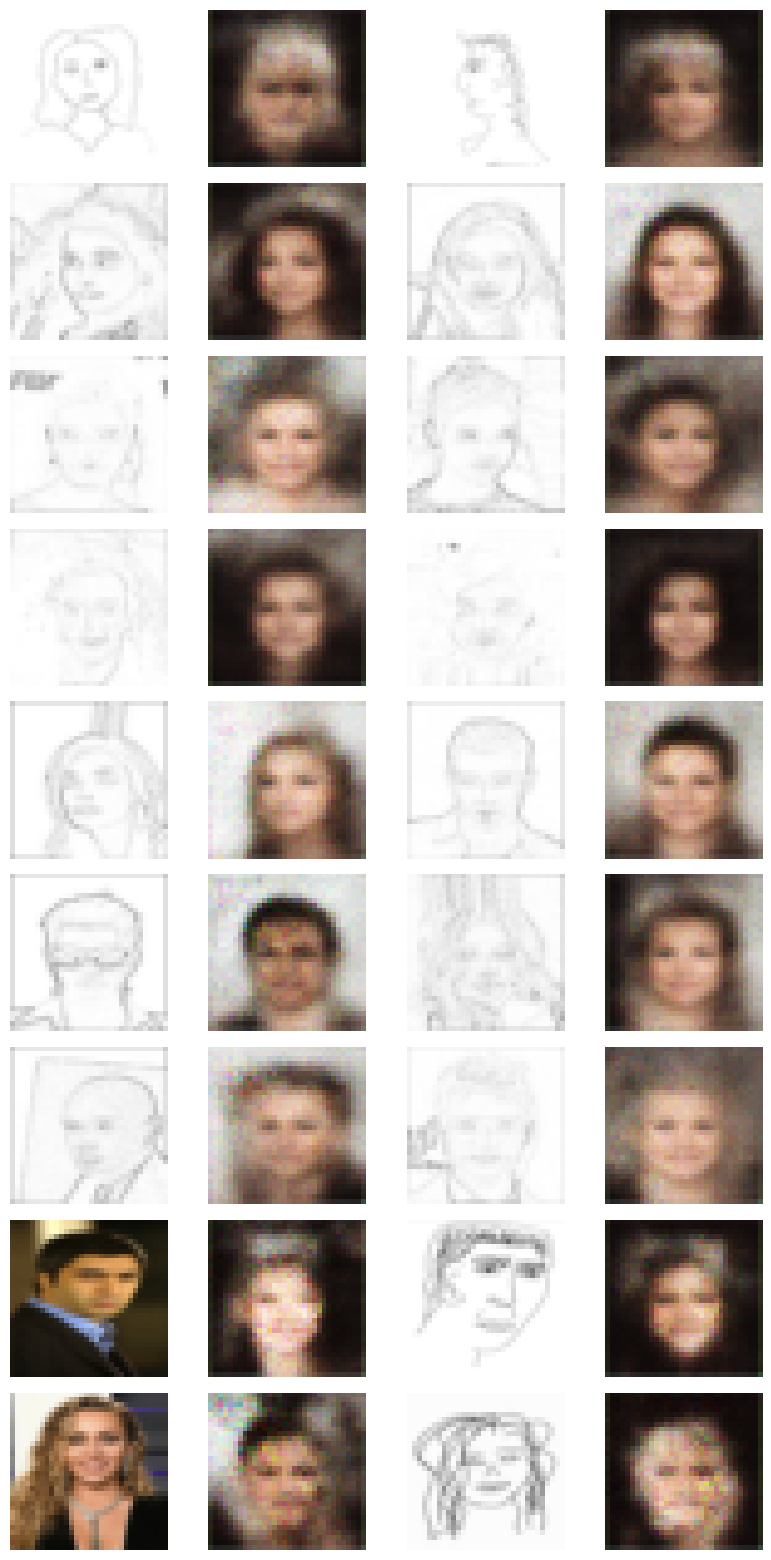

In [4]:
# Pretrained model

# Set the model to evaluation mode
net.eval()

#sample(net, e, batch_size=2)
#calc_inception_score(net, e)
#calc_autoencoder_frechet_distance(net, e)
#calc_clean_fid(net, e)

# Plot the first batch from the test_loader
plot(net, test_loader, 0)

In [6]:
for batch_idx, (real_img, targets) in enumerate(train_loader.dataset):
    #print(batch_idx)
    real_img = real_img.to(init_device, non_blocking=True)
    targets = (1+targets.to(init_device, non_blocking=True))/2
    # direct spike input
    spike_input = real_img.unsqueeze(-1).repeat(1, 1, 1, 1, 16) # (N,C,H,W,T)
    exp_features = net(spike_input) # sampled_z(N,num_classes,T)
    print(exp_features)
    print(targets)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 3, 3, 3], but got 5-dimensional input of size [1, 3, 32, 32, 16] instead

In [ ]:
        torch.save(net.state_dict(), f'checkpoint/{args.name}/best.pth')

In [ ]:
train_loader.dataset.targets